# Initialize

In [187]:
%pip install spylls
%pip install pagexml-tools
%pip install tqdm
%pip install pandas matplotlib seaborn scikit-learn

%conda install python-graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [188]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [189]:
from pathlib import Path

REPOSITORY_PATH = Path().parent.absolute()
REPOSITORY_PATH

PosixPath('/Users/carstenschnober/LAHTeR/workspace/nautilusocr')

# Dictionary Lookup

In [190]:
LANGUAGE = "nl"

HUNSPELL_DICT_PATH = REPOSITORY_PATH / 'dicts'
assert HUNSPELL_DICT_PATH.is_dir()

SUFFIXES = [".aff", ".dic"]

assert HUNSPELL_DICT_PATH.is_dir()

assert all(
    (HUNSPELL_DICT_PATH / Path(LANGUAGE).with_suffix(suffix)).is_file()
    for suffix in [".aff", ".dic"]
)



In [191]:
from spylls.hunspell import Dictionary

hunspell = Dictionary.from_files(str(HUNSPELL_DICT_PATH / Path(LANGUAGE)))

In [192]:
from typing import List


def get_dict_score(tokens: List[str]):
    if any(len(token) > 0 for token in tokens):
        matched_count = 0
        total_count = 0

        for token in tokens:
            total_count += len(token)

            # TODO: lowercase token?
            matched_count += hunspell.lookup(token) * len(token)

        return matched_count / total_count
    else:
        return 0.0



In [193]:
tokens = ["Dit", "is", "een", "text"]

get_dict_score(tokens)

0.6666666666666666

# Train Tri-Gram Model

## Functions

In [194]:
from typing import List


HYPHENS = {"-", "⸗", "="}


def get_tokens(text) -> List[str]:
    """Copied from features_epr.py"""

    tokens = list()

    new_token = ""
    for c in text:
        if c == " " and len(new_token) > 0:
            tokens.append(new_token)
            new_token = ""
        elif c == "\n" and len(new_token) > 0:
            if new_token[-1] in HYPHENS:
                new_token = new_token[:-1]
            else:
                tokens.append(new_token)
                new_token = ""
        else:
            new_token += c
    if len(new_token) > 0:
        tokens.append(new_token)

    for i, token in enumerate(tokens):
        if not token[-1].isalpha():
            tokens[i] = token[:-1]
        if not token[0].isalpha():
            tokens[i] = token[1:]

    return tokens


In [195]:
from typing import List


NGRAM_LENGTH = 3


def get_ngrams(tokens) -> List[str]:
    """Copied, adapted from features_epr.py"""

    n_grams = list()
    for token in tokens:
        token_list = list(token)
        for i in range(0, len(token_list)):
            if not token[i].isalpha():
                token_list[i] = " "
        modified_token = "".join(token_list)
        splits = modified_token.split(" ")
        for split in splits:
            if split != "":
                for i in range(0, len(split) - NGRAM_LENGTH + 1):
                    n_grams.append(split[i : i + NGRAM_LENGTH].lower())
    return n_grams


In [196]:
def get_ngram_score(ngrams, lang_ngrams) -> float:
    """Copied from features_epr.py"""
    # TODO: this is very slow
    # TODO: check if this corresponds to equation 10 in the paper?

    if len(ngrams) == 0:
        return 0

    score = 0
    for ngram in ngrams:
        for i in range(0, len(lang_ngrams)):
            if ngram == lang_ngrams[i]:
                score += 1 - (1 / len(lang_ngrams) * i)
                break

    score = score / len(ngrams)
    return score


## Read Ground Truth

In [197]:
# Download and decompress "VOC Ground truths of the trainingset in PAGE xml.7z" from https://zenodo.org/record/6414086

GROUND_TRUTH_PATH = REPOSITORY_PATH / "VOC Ground truths of the trainingset in PAGE xml"
assert (
    GROUND_TRUTH_PATH.is_dir()
), f"Directory containing ground truth not found at {GROUND_TRUTH_PATH.absolute()}"



In [198]:
import random
from collections import Counter

from pagexml.parser import parse_pagexml_file
from tqdm import tqdm

N_FILES = 50

random.seed(1)

files = list(GROUND_TRUTH_PATH.glob("*.xml"))

pagexml_files = random.sample(files, N_FILES)

lang_trigrams = list()

for file in tqdm(pagexml_files, desc="Reading PageXML files", unit="file"):
    pagexml = parse_pagexml_file(file)
    for line in pagexml.get_lines():
        tokens = get_tokens(line.text) if line.text else []
        lang_trigrams.extend(get_ngrams(tokens))

print(f"Total n-grams: {len(lang_trigrams)}")
print(f"Distinct n-grams: {len(set(lang_trigrams))}")
print(f"Most common n-grams: ")

Counter(lang_trigrams).most_common(10)


Reading PageXML files: 100%|██████████| 50/50 [00:01<00:00, 25.95file/s]

Total n-grams: 26714
Distinct n-grams: 2536
Most common n-grams: 


[('nde', 418),
 ('den', 394),
 ('van', 340),
 ('der', 294),
 ('ver', 251),
 ('oor', 236),
 ('eer', 230),
 ('ten', 213),
 ('gen', 205),
 ('ren', 199)]

In [199]:
import os

os.linesep.join([line.text for line in pagexml.get_lines()])

"Van Bengale onder dato 5:' Maert 1733.\nAug: 1732.\nEen brief van't Eerwaarde Collegie\nvan Heeren weesmeesteren ter\ngemelte Stede gedagtekent op\nden 11. bevorens, en\nEen d„to door de bediendens tot\nNangasackij in Iapan herwaards\ngezonden op den 20:' 8ber: A„o pass:o\nIngevolge van 't gedisponeerde in dese bij„\neenkomst, word den sergeant Nicolaas\nWiebemer benevens een Corporaal en 12\ngemeene soldaten gecommandeert en\nmet de nodige ordonnantien afgezon„\n„den om het geld uit beide de aangeko„\n„mene schepen bovengem:' af te halen.\nSondag 17:' voor de middag passeert onder faveur\nvan de vloed opwaard aan ’S E:e Comp=s\nLoge voorbij een moors Schip.\nKomende met dat Zelve tije ook van't\nbepeilen en examineren der I:o gearriveer„\n„ de drie schepen in loco terug den fiscaal,\nIoan Anzelmus Thielen en den dorp\n„meester Anthonij Fredrik Conink\nterwijl het indato 13:' deser mede\nafgegane"

In [200]:
text = "Dit is eenasd teksthdgfhfgh"

tokens = get_tokens(text)
trigrams = get_ngrams(tokens)

get_ngram_score(trigrams, lang_trigrams)

0.3195094332559707

In [201]:
file = random.choice(files)
while file in pagexml_files:
    # raise ValueError(f"Test file '{file}' must not be in sample of training files.")
    file = random.choice(files)
parse_pagexml_file(file)


scores = Counter()
file_trigrams = list()

for line in pagexml.get_lines():
    text = line.text
    tokens = get_tokens(text)
    line_trigrams = get_ngrams(tokens)
    scores[text] = get_ngram_score(line_trigrams, lang_trigrams)

    file_trigrams.extend(line_trigrams)

scores.most_common()



[('Een d„to door de bediendens tot', 0.9848331711212598),
 ('van Heeren weesmeesteren ter', 0.9718785919698419),
 ("Komende met dat Zelve tije ook van't", 0.9690718617311415),
 ("Van Bengale onder dato 5:' Maert 1733.", 0.9670932309436465),
 ('gemeene soldaten gecommandeert en', 0.9634478346389703),
 ("terwijl het indato 13:' deser mede", 0.9535125152853685),
 ('den 11. bevorens, en', 0.9422239810051444),
 ("gezonden op den 20:' 8ber: A„o pass:o", 0.9413827955379201),
 ('gemelte Stede gedagtekent op', 0.9372151196332392),
 ("Ingevolge van 't gedisponeerde in dese bij„", 0.9233650043899352),
 ("Een brief van't Eerwaarde Collegie", 0.9227600176353639),
 ('met de nodige ordonnantien afgezon„', 0.9127798158269073),
 ('„meester Anthonij Fredrik Conink', 0.9100284495021336),
 ('„den om het geld uit beide de aangeko„', 0.9076859727829256),
 ('afgegane', 0.9059793865888048),
 ('Loge voorbij een moors Schip.', 0.8946245414389458),
 ('Wiebemer benevens een Corporaal en 12', 0.8861065358987796),


In [202]:
get_ngram_score(file_trigrams, lang_trigrams)

0.8786059013543644

# Garbage Token Detection

## Functions

In [203]:
EPR_RULE1 = 21
EPR_RULE2 = 3
EPR_RULE3 = 4
EPR_RULE4 = 6
EPR_RULE5 = 8
EPR_RULE9 = 2

VOWELS = "aäàáâǎeéèêëěiîïíìıoöôòóǒuüûùúǔ"


def get_garbage_score(tokens):
    """Copied from features_epr.py"""

    issues = 0

    if len(tokens) == 0:
        return 0

    for token in tokens:

        # rule1
        if len(token) >= EPR_RULE1:
            issues += 1
            continue

        vowel_count = 0
        consonant_count = 0
        lower_case_count = 0
        upper_case_count = 0
        special_char_count = 0
        non_outer_special_chars = set()
        alpha = True
        last_char = None
        repitition_streak = 0
        vowel_streak = 0
        consonant_streak = 0
        go_to_next_token = False
        for i in range(0, len(token)):
            go_to_next_token = False
            char = token[i]

            # collect token info
            if char.isalpha():
                if char.lower() in VOWELS:
                    vowel_count += 1
                    vowel_streak += 1
                    consonant_streak = 0
                else:
                    consonant_count += 1
                    consonant_streak += 1
                    vowel_streak = 0
                if char.isupper():
                    upper_case_count += 1
                else:
                    lower_case_count += 1
            elif char.isalnum():
                alpha = False
                vowel_streak = 0
                consonant_streak = 0
            else:
                special_char_count += 1
                alpha = False
                vowel_streak = 0
                consonant_streak = 0
                if i != 0 and i != len(token) - 1:
                    non_outer_special_chars.add(char)

            # rule 3
            if vowel_streak >= EPR_RULE3:
                issues += 1
                go_to_next_token = True
                break

            # rule 4
            if consonant_streak >= EPR_RULE4:
                issues += 1
                go_to_next_token = True
                break

            if last_char != None and char == last_char:
                repitition_streak += 1

                # rule 2
                if repitition_streak >= EPR_RULE2:
                    issues += 1
                    go_to_next_token = True
                    break
            else:
                repitition_streak = 0
            last_char = char

        if go_to_next_token:
            continue

        if alpha and vowel_count > 0 and consonant_count > 0:
            # rule 5
            if vowel_count * EPR_RULE5 < consonant_count:
                issues += 1
                continue
            # rule 5
            if consonant_count * EPR_RULE5 < vowel_count:
                issues += 1
                continue

        # rule 6
        if lower_case_count > 0 and upper_case_count > lower_case_count:
            issues += 1
            continue

        # rule 7
        if (
            upper_case_count > 0
            and token[0].islower()
            and token[len(token) - 1].islower()
        ):
            issues += 1
            continue

        # rule 8
        regular_chars = len(token) - special_char_count
        if special_char_count >= regular_chars and regular_chars > 0:
            issues += 1
            continue

        # rule 9
        if len(non_outer_special_chars) >= EPR_RULE9:
            issues += 1
            continue

    return issues / len(tokens)



In [204]:
get_garbage_score(get_tokens(text))

0.0

# Publication Year Consideration

In [205]:
# TODO: Fill in correct year range
MIN_YEAR = 1500
MAX_YEAR = 1800


def scale_year(year):
    """Copied from features_epr.py"""

    scaled_year = (year - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    scaled_year = max(min(1.0, scaled_year), 0.0)
    return scaled_year


In [206]:
scale_year(1800)

1.0

# Scoring

In [207]:
DATA_DIR = REPOSITORY_PATH / "data"
assert DATA_DIR.is_dir()

In [208]:
JUDGEMENTS_FILE = DATA_DIR / "limited2 review overview 20220713.csv"
assert JUDGEMENTS_FILE.is_file()

In [209]:
PAGES_DIR = DATA_DIR / "page"
assert PAGES_DIR.is_dir()

## Read Judgements

In [210]:
import pandas as pd

judgements = pd.read_csv(JUDGEMENTS_FILE, index_col=0).rename({"Unnamed: 11": "url"}, axis="columns")
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN
...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN


In [211]:
judgements[["Ranking Kay", "Ranking Maartje"]].corr()

,Ranking Kay,Ranking Maartje
Ranking Kay,1.000000,0.626003
Ranking Maartje,0.626003,1.000000


## Read and Process Pages

In [212]:
def tokenize_pagexml(path: Path) -> List[str]:
    parse_pagexml_file(path).text


In [213]:
judgements["path"] = judgements.Filename.apply(lambda f: PAGES_DIR / (f + ".xml"))
assert judgements["path"].apply(Path.is_file).all()
judgements

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...


In [214]:
judgements["pagexml"] = judgements.path.apply(parse_pagexml_file)
judgements

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....


In [215]:
judgements["lines"] = judgements.pagexml.apply(lambda pagexml: [line.text for line in pagexml.get_lines()if line.text])
judgements

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc..."
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors..."
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon..."
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p..."
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do..."
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be..."
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ..."


In [216]:
import os

judgements["text"] = judgements.lines.apply(lambda l: os.linesep.join(l))
judgements


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines,text
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco..."
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo..."
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be...","hoe hij dat wijs, en daar op ten\nantwoord bek..."
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ...","verkeerd, hun leven verbeuid hebben, en, na\nh..."


In [217]:
judgements["tokens"] = judgements.text.apply(get_tokens)
judgements

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines,text,tokens
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco...","[Alsoo, den, coninck, van, Jaccatia, tegen, he..."
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...,"[e, geer, de, der, e, C=t, Ce, e, JJer, sercs,..."
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...,"[eersdat, naer, alle, apparentie, met, des, co..."
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...,"[aaij, bijcis, ij, , Han, Commissariis, Mr, An..."
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...,"[ee, eve, ee, evee, e, een, 19, eeeee, eeee, e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...,"[Zynde, geweest, en, deselve, ten, getale, van..."
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo...","[heeft, waargenoomen, maar, het, selve, altoos..."
497,498,Medium,Regelherkenning,2,slecht,leesvolgorde,3,5,NL-HaNA_1.04.02_10969_0121,10969,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10969_0121....,"[hoe hij dat wijs, en daar op ten, antwoord be...","hoe hij dat wijs, en daar op ten\nantwoord bek...","[hoe, hij, dat, wijs, en, daar, op, ten, antwo..."
498,499,Goed,NaN,1,goed,moeite met getallen,1,2,NL-HaNA_1.04.02_10975_0260,10975,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10975_0260....,"[verkeerd, hun leven verbeuid hebben, en, na, ...","verkeerd, hun leven verbeuid hebben, en, na\nh...","[verkeerd, hun, leven, verbeuid, hebben, en, n..."


In [218]:
judgements.iloc[judgements.Som.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines,text,tokens
192,193,Gedrukt?!,NaN,0,onbekend,gedrukte pagina,0,0,NL-HaNA_1.04.02_2659_0164,2659,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2659_0164.j...,"[32-, L O 1 V L L 2C, der t‛act van de traneve...",32-\nL O 1 V L L 2C\nder t‛act van de tranever...,"[2L, O, , V, L, L, C, der, t‛act, van, de, tra..."
93,94,Goed!,NaN,0,goed,NaN,1,1,NL-HaNA_1.04.02_1851_0707,1851,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1851_0707.j...,"[Heden den 3: Februarij 1714:, Compareerden vo...",Heden den 3: Februarij 1714:\nCompareerden voo...,"[Heden, den, :, Februarij, 714:, Compareerden,..."
187,188,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_2646_0018,2646,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2646_0018.j...,[],,[]
33,34,Leeg,NaN,0,goed,leeg; transcriptie die er niet hoort,1,1,NL-HaNA_1.04.02_1306_0327,1306,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1306_0327.j...,"[ve e, eerere, 3„ 6 „]",ve e\neerere\n3„ 6 „,"[ve, e, eerere, „, , ]"
479,480,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_10703_0018,10703,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10703_0018....,[W. 9],W. 9,"[W, ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,108,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1967_1068,1967,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1967_1068.j...,"[19/6, eeeee, „ - 3: . .]",19/6\neeeee\n„ - 3: . .,"[9/6, eeeee, , , :, , ]"
108,109,Slecht,NaN,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_1968_0696,1968,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1968_0696.j...,[1:],1:,[:]
117,118,Slecht,Layout,3,slecht,layout,3,6,NL-HaNA_1.04.02_2036_0307,2036,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2036_0307.j...,"[uytslag van saken tot tyd en, inslateur, S —,...",uytslag van saken tot tyd en\ninslateur\nS —\n...,"[uytslag, van, saken, tot, tyd, en, inslateur,..."
439,440,Slecht,Regelvolgorde,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_9751_0010,9751,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9751_0010.j...,[Den 30.' maart zijn de kleeden 'smorgens vers...,Den 30.' maart zijn de kleeden 'smorgens versc...,"[Den, 0.', maart, zijn, de, kleeden, smorgens,..."


## Compute Features

### Dictionary Scores

In [219]:
judgements["dict_score"] = judgements.tokens.apply(get_dict_score)
judgements.iloc[judgements.dict_score.sort_values().index]


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines,text,tokens,dict_score
474,475,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10633_0002,10633,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10633_0002....,[],,[],0.000000
456,457,Slecht,Regiodetectie/Volgorde,3,goed,leeg,1,4,NL-HaNA_1.04.02_10124_0230,10124,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10124_0230....,[],,[],0.000000
24,25,Leeg,NaN,0,goed,leeg; transcriptie die er niet hoort,1,1,NL-HaNA_1.04.02_1269_1040,1269,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1269_1040.j...,[],,[],0.000000
434,435,Leeg,NaN,0,medium,leeg; transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9534_0129,9534,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9534_0129.j...,[],,[],0.000000
317,318,Leeg,NaN,0,medium,leeg; transcriptie die er niet hoort,2,2,NL-HaNA_1.04.02_4426_0769,4426,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4426_0769.j...,"[„, _]",„\n_,"[, ]",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,304,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_4071_1018,4071,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4071_1018.j...,"[p„s,, . Co, Sententie van, Jacobus de Bruy]","p„s,\n. Co\nSententie van\nJacobus de Bruy","[p„s, , Co, Sententie, van, Jacobus, de, Bruy]",0.766667
92,93,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1851_0827,1851,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1851_0827.j...,[1004],1004,[004],1.000000
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10675_0578....,[tee],tee,[tee],1.000000
479,480,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_10703_0018,10703,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10703_0018....,[W. 9],W. 9,"[W, ]",1.000000


### Tri-gram Scores

In [220]:
# TODO: hardcode `lang_trigrams` parameter in get_ngram_score(), remove lambda wrapper
judgements["n_gram_score"] = judgements.tokens.apply(
    lambda t: get_ngram_score(t, lang_trigrams)
)
judgements.iloc[judgements.n_gram_score.sort_values().index]



,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines,text,tokens,dict_score,n_gram_score
144,145,Goed (leeg),NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_2275_0078,2275,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2275_0078.j...,[],,[],0.000000,0.000000
24,25,Leeg,NaN,0,goed,leeg; transcriptie die er niet hoort,1,1,NL-HaNA_1.04.02_1269_1040,1269,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1269_1040.j...,[],,[],0.000000,0.000000
269,270,Slecht,Tekst,3,slecht,transcriptie,3,6,NL-HaNA_1.04.02_3552_0482,3552,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_3552_0482.j...,"[eeere, ereee, „ „., .. . . . . . .]",eeere\nereee\n„ „.\n.. . . . . . .,"[eeere, ereee, , ., ., , , , , , ]",0.000000,0.000000
479,480,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_10703_0018,10703,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10703_0018....,[W. 9],W. 9,"[W, ]",1.000000,0.000000
314,315,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_4405_0237,4405,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_4405_0237.j...,[],,[],0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,464,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10356_1047,10356,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10356_1047....,"[Ge, 100 /3 - -, Den 20: Febr: In De Stad Coch...",Ge\n100 /3 - -\nDen 20: Febr: In De Stad Cochi...,"[Ge, 00, 3, , Den, 0:, Febr, In, De, Stad, Coc...",0.509240,0.292817
336,337,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_7893_0137,7893,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_7893_0137.j...,"[Iavas Oostcust den 27:e Iunij 1743, Mijn heer...",Iavas Oostcust den 27:e Iunij 1743\nMijn heer....,"[Iavas, Oostcust, den, 7:e, Iunij, 743, Mijn, ...",0.502216,0.295731
111,112,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1988_1109,1988,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1988_1109.j...,[Van nadien het van oudsher een gebruijk gewee...,Van nadien het van oudsher een gebruijk gewees...,"[Van, nadien, het, van, oudsher, een, gebruijk...",0.655963,0.319348
476,477,Leeg,NaN,0,goed,leeg; 1 transcriptie,1,1,NL-HaNA_1.04.02_10675_0578,10675,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10675_0578....,[tee],tee,[tee],1.000000,0.981695


### Garbage Token Scores

In [221]:
judgements["garbage_score"] = judgements.tokens.apply(get_garbage_score)
judgements.iloc[judgements.garbage_score.sort_values().index]

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines,text,tokens,dict_score,n_gram_score,garbage_score
378,379,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8831_0064,8831,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8831_0064.j...,"[Van Cormandel den 18 aug 1719, tot fiscael en...",Van Cormandel den 18 aug 1719\ntot fiscael en\...,"[Van, Cormandel, den, 8, aug, 719, tot, fiscae...",0.534548,0.212975,0.000000
85,86,Goed?,Heel veel van andere pagina's,0,slecht,NaN,3,3,NL-HaNA_1.04.02_1785_0028,1785,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1785_0028.j...,[agtb: gunst te continueren over den raad van ...,agtb: gunst te continueren over den raad van j...,"[agtb, gunst, te, continueren, over, den, raad...",0.742475,0.249146,0.000000
387,388,Slecht,Tekst en regelherkenning,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_8960_0003,8960,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8960_0003.j...,"[ommis, Ge, Van, e Ven, M, Ce, Ge Ce, V: Cr, C...",ommis\nGe\nVan\ne Ven\nM\nCe\nGe Ce\nV: Cr\nCe...,"[ommis, Ge, Van, e, Ven, M, Ce, Ge, Ce, V, Cr,...",0.404762,0.000000,0.000000
131,132,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2155_0281,2155,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2155_0281.j...,"[en palicoll buijten kennisse van, mooren teli...",en palicoll buijten kennisse van\nmooren telic...,"[en, palicoll, buijten, kennisse, van, mooren,...",0.524217,0.141866,0.000000
388,389,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8970_1586,8970,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8970_1586.j...,"[Van Ceijlon onder dato 25 Septemb:r 1716, p. ...",Van Ceijlon onder dato 25 Septemb:r 1716\np. ....,"[Van, Ceijlon, onder, dato, 5, Septemb:r, 716,...",0.469930,0.132186,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,437,Leeg,NaN,0,medium,leeg; 1 transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9594_0147,9594,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9594_0147.j...,"[6e 8, 9, eeeee, ve ee]",6e 8\n9\neeeee\nve ee,"[e, , , eeeee, ve, ee]",0.100000,0.000000,0.166667
4,5,Leeg,NaN,0,goed,leeg,1,1,NL-HaNA_1.04.02_1110_0782,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0782.j...,"[ee eve, ee evee, e een, 119, eeeee, eeee, 1e ...",ee eve\nee evee\ne een\n119\neeeee\neeee\n1e e...,"[ee, eve, ee, evee, e, een, 19, eeeee, eeee, e...",0.173448,0.069238,0.178344
432,433,Leeg,NaN,0,medium,leeg; transcriptie die er niet is,2,2,NL-HaNA_1.04.02_9467_0563,9467,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9467_0563.j...,"[eeere, eeeee, eve e en]",eeere\neeeee\neve e en,"[eeere, eeeee, eve, e, en]",0.187500,0.187100,0.200000
337,338,Slecht,Layout,3,medium,leesvolgorde; ditto,2,5,NL-HaNA_1.04.02_7950_0317,7950,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_7950_0317.j...,"[Baguala, ten overstaan van dies Restherdiers,...","Baguala, ten overstaan van dies Restherdiers, ...","[Baguala, ten, overstaan, van, dies, Restherdi...",0.321101,0.056073,0.211009


### Publication Year

Ground truth missing year information

## Preprocessing and Filtering

In [222]:
judgements["quality"] = np.ceil(judgements.Som / 2).astype(int)
judgements.iloc[judgements.quality.sort_values().index]

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines,text,tokens,dict_score,n_gram_score,garbage_score,quality
192,193,Gedrukt?!,NaN,0,onbekend,gedrukte pagina,0,0,NL-HaNA_1.04.02_2659_0164,2659,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2659_0164.j...,"[32-, L O 1 V L L 2C, der t‛act van de traneve...",32-\nL O 1 V L L 2C\nder t‛act van de tranever...,"[2L, O, , V, L, L, C, der, t‛act, van, de, tra...",0.580477,0.183855,0.006452,0
151,152,goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2314_1588,2314,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2314_1588.j...,"[: Van, Aldus gepasseert en besloten tot Timor...",: Van\nAldus gepasseert en besloten tot Timor ...,"[, Van, Aldus, gepasseert, en, besloten, tot, ...",0.587192,0.116877,0.019139,1
392,393,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_8990_0164,8990,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8990_0164.j...,"[150., van mallebaer onder p„mo novemb: 1703.,...",150.\nvan mallebaer onder p„mo novemb: 1703.\n...,"[50., van, mallebaer, onder, p„mo, novemb, 703...",0.439437,0.173165,0.019231,1
180,181,goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2579_0251,2579,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2579_0251.j...,"[Van, den soldaet Willem Luijcke van, Gellenbe...",Van\nden soldaet Willem Luijcke van\nGellenbee...,"[Van, den, soldaet, Willem, Luijcke, van, Gell...",0.554483,0.214230,0.011236,1
181,182,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_2585_0213,2585,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_2585_0213.j...,[Van Cabo De goede hoop onder dato 26 feb: 174...,Van Cabo De goede hoop onder dato 26 feb: 1742...,"[Van, Cabo, De, goede, hoop, onder, dato, 6, f...",0.589958,0.229223,0.009009,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,373,Slecht,Regio-indeling,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_8784_0928,8784,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_8784_0928.j...,"[Van Bengale Den 31:' maart A:o 1731;, P„r Tra...",Van Bengale Den 31:' maart A:o 1731;\nP„r Tran...,"[Van, Bengale, Den, 1:', maart, A:o, 731;, P„r...",0.414695,0.054518,0.035088,3
215,216,Slecht,NaN,3,slecht,layout; leesvolgorde,3,6,NL-HaNA_1.04.02_3010_0357,3010,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_3010_0357.j...,[164.— „ 2. -. Packen Per Transport met P o/ 1...,164.— „ 2. -. Packen Per Transport met P o/ 15...,"[64.—, , ., ., Packen, Per, Transport, met, P,...",0.432035,0.132252,0.054363,3
219,220,Slecht,NaN,3,medium,layout; leesvolgorde,2,5,NL-HaNA_1.04.02_3018_0173,3018,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_3018_0173.j...,[In 'T Casteel Alombo ende maand November 1700...,In 'T Casteel Alombo ende maand November 1700....,"[In, T, Casteel, Alombo, ende, maand, November...",0.513909,0.079137,0.023861,3
394,395,Slecht,Regelherkenning en indeling,3,slecht,leesvolgorde; layout,3,6,NL-HaNA_1.04.02_9009_0451,9009,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_9009_0451.j...,"[a onder dato 30„en April 1727, ordanee, ge Co...",a onder dato 30„en April 1727\nordanee\nge Coo...,"[a, onder, dato, 0„en, April, 727, ordanee, ge...",0.254593,0.044084,0.100358,3


In [256]:
non_empty = judgements.loc[(judgements.text.str.len() > 0)]
agreement = judgements.loc[judgements["Ranking Kay"] == judgements["Ranking Maartje"]]

# filtered = judgements.loc[
#     (judgements.text.str.len() > 0)
#     & (judgements["Ranking Kay"] == judgements["Ranking Maartje"])
# ]

filtered = judgements.iloc[non_empty.index.intersection(agreement.index)]
filtered


,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,url,path,pagexml,lines,text,tokens,dict_score,n_gram_score,garbage_score,quality
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1069_0506.j...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco...","[Alsoo, den, coninck, van, Jaccatia, tegen, he...",0.378567,0.178038,0.002915,2
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1108_1273.j...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...,"[e, geer, de, der, e, C=t, Ce, e, JJer, sercs,...",0.428164,0.142994,0.005540,1
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0301.j...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...,"[eersdat, naer, alle, apparentie, met, des, co...",0.315423,0.158830,0.003407,3
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1110_0777.j...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...,"[aaij, bijcis, ij, , Han, Commissariis, Mr, An...",0.321451,0.094553,0.017182,2
5,6,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1111_0725,1111,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_1111_0725.j...,"[dat hem t' selve mach ter ham gestelt werden,...","dat hem t' selve mach ter ham gestelt werden, ...","[dat, hem, t, selve, mach, ter, ham, gestelt, ...",0.418023,0.200714,0.008772,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,491,Goed,NaN,1,goed,ditto teken,1,2,NL-HaNA_1.04.02_10871_0141,10871,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10871_0141....,"[Door den Quid Lieutenant ter zee Christiaan, ...",Door den Quid Lieutenant ter zee Christiaan\nE...,"[Door, den, Quid, Lieutenant, ter, zee, Christ...",0.601751,0.135419,0.026718,1
491,492,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_10884_0593,10884,https://www.nationaalarchief.nl/onderzoeken/ar...,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10884_0593....,"[Henrixis Blanken„, „berg, omme betaald, te we...","Henrixis Blanken„\n„berg, omme betaald\nte wer...","[Henrixis, Blanken, berg,, omme, betaald, te, ...",0.485714,0.104599,0.025641,3
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10899_0130....,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...,"[Zynde, geweest, en, deselve, ten, getale, van...",0.569307,0.192985,0.008197,1
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,NaN,/Users/carstenschnober/LAHTeR/workspace/nautil...,PageXMLScan(\n\tid=NL-HaNA_1.04.02_10953_0290....,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo...","[heeft, waargenoomen, maar, het, selve, altoos...",0.604352,0.246871,0.000000,1


([<matplotlib.axis.XTick at 0x7f8f37941900>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

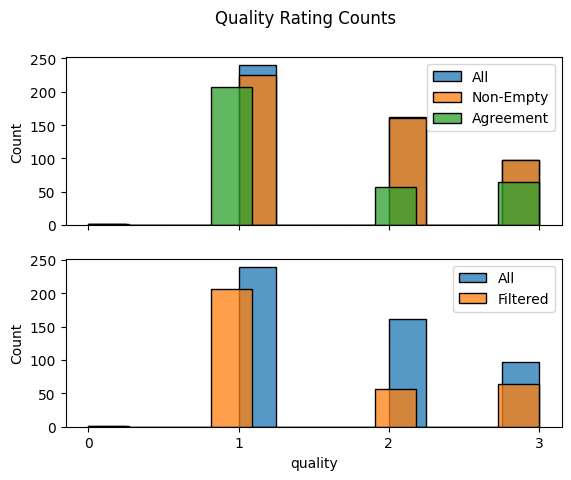

In [277]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)

fig.suptitle("Quality Rating Counts")

sns.color_palette("tab10")

#ax1.set_title("Filtering Steps")
sns.histplot(judgements.quality, label="All", ax=ax1)
sns.histplot(non_empty.quality, label="Non-Empty", ax=ax1)
sns.histplot(agreement.quality, label="Agreement", ax=ax1)

#ax2.set_title("Total")
sns.histplot(judgements.quality, label="All", ax=ax2)
sns.histplot(filtered.quality, label="Filtered", ax=ax2)

ax1.legend()
ax2.legend()

plt.xticks(range(4))



## Plot Features

<Axes: title={'center': 'Garbage Scores'}, xlabel='quality', ylabel='garbage_score'>

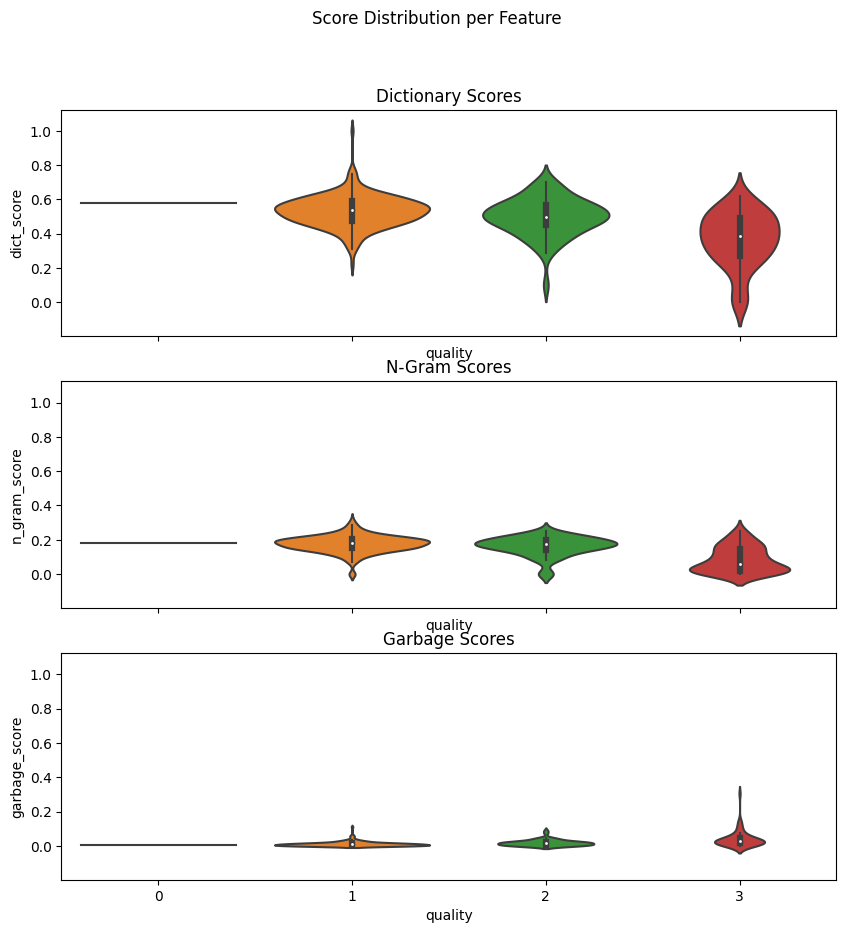

In [290]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 10), sharex=True, sharey=True)

fig.suptitle("Score Distribution per Feature")
ax1.set_title("Dictionary Scores")
ax2.set_title("N-Gram Scores")
ax3.set_title("Garbage Scores")

sns.violinplot(x=filtered.quality, y=filtered.dict_score, ax=ax1)
sns.violinplot(x=filtered.quality, y=filtered.n_gram_score, ax=ax2)
sns.violinplot(x=filtered.quality, y=filtered.garbage_score, ax=ax3)



## Classify

In [227]:
x_fields = ["dict_score", "n_gram_score", "garbage_score"]
# x_fields = ["dict_score", "n_gram_score"]
#x_fields = ["dict_score", "garbage_score"]
# x_fields = ["dict_score"]

x_fields_normalized = [field + "_normalized" for field in x_fields]

y_field = "quality"


In [228]:
filtered[x_fields].max(), filtered[x_fields].min()


(dict_score       1.000000
 n_gram_score     0.319348
 garbage_score    0.305714
 dtype: float64,
 dict_score       0.0
 n_gram_score     0.0
 garbage_score    0.0
 dtype: float64)

In [292]:
# TODO: refactor for vector operation instead of for loop
for field, normalized_field in zip(x_fields, x_fields_normalized):
    assert (
        filtered[field].min() == 0.0
    ), "If the minimum is not 0.0, the formula must be adapted"

    _max = filtered[field].max()
    filtered[normalized_field] = filtered[field].apply(lambda x: x / _max)
filtered


/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_11159/3944033321.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[normalized_field] = filtered[field].apply(lambda x: x / _max)
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_11159/3944033321.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[normalized_field] = filtered[field].apply(lambda x: x / _max)
/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/ipykernel_11159/3944033321.py:8: SettingWithCopyWarning: 
A value

,Pagina,Beoordeling,Opmerkingen Kay,Ranking Kay,Oordeel Maartje,Opmerkingen Maartje,Ranking Maartje,Som,Filename,Invno,...,lines,text,tokens,dict_score,n_gram_score,garbage_score,quality,dict_score_normalized,n_gram_score_normalized,garbage_score_normalized
0,1,Medium,Tekst,2,medium,NaN,2,4,NL-HaNA_1.04.02_1069_0506,1069,...,"[Alsoo den coninck van Jaccatia, tegen het acc...","Alsoo den coninck van Jaccatia, tegen het acco...","[Alsoo, den, coninck, van, Jaccatia, tegen, he...",0.378567,0.178038,0.002915,2,0.378567,0.557505,0.009537
1,2,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1108_1273,1108,...,"[e geer de der, e C=t Ce e, 2JJer sercs, Moors...",e geer de der\ne C=t Ce e\n2JJer sercs\nMoors ...,"[e, geer, de, der, e, C=t, Ce, e, JJer, sercs,...",0.428164,0.142994,0.005540,1,0.428164,0.447767,0.018122
2,3,Slecht,Leesvolgorde en tekst,3,slecht,NaN,3,6,NL-HaNA_1.04.02_1110_0301,1110,...,[eersdat naer alle apparentie met des comp=es ...,eersdat naer alle apparentie met des comp=es s...,"[eersdat, naer, alle, apparentie, met, des, co...",0.315423,0.158830,0.003407,3,0.315423,0.497356,0.011145
3,4,Medium,Leesvolgorde,2,medium,NaN,2,4,NL-HaNA_1.04.02_1110_0777,1110,...,"[aaij bijcis 1ij 1, Han Commissariis Mr Anthon...",aaij bijcis 1ij 1\nHan Commissariis Mr Anthoni...,"[aaij, bijcis, ij, , Han, Commissariis, Mr, An...",0.321451,0.094553,0.017182,2,0.321451,0.296082,0.056203
5,6,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_1111_0725,1111,...,"[dat hem t' selve mach ter ham gestelt werden,...","dat hem t' selve mach ter ham gestelt werden, ...","[dat, hem, t, selve, mach, ter, ham, gestelt, ...",0.418023,0.200714,0.008772,1,0.418023,0.628510,0.028693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,491,Goed,NaN,1,goed,ditto teken,1,2,NL-HaNA_1.04.02_10871_0141,10871,...,"[Door den Quid Lieutenant ter zee Christiaan, ...",Door den Quid Lieutenant ter zee Christiaan\nE...,"[Door, den, Quid, Lieutenant, ter, zee, Christ...",0.601751,0.135419,0.026718,1,0.601751,0.424048,0.087394
491,492,Slecht,Regioherkenning,3,slecht,leesvolgorde,3,6,NL-HaNA_1.04.02_10884_0593,10884,...,"[Henrixis Blanken„, „berg, omme betaald, te we...","Henrixis Blanken„\n„berg, omme betaald\nte wer...","[Henrixis, Blanken, berg,, omme, betaald, te, ...",0.485714,0.104599,0.025641,3,0.485714,0.327539,0.083873
495,496,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10899_0130,10899,...,"[Zynde geweest en deselve ten getale, van 22 p...",Zynde geweest en deselve ten getale\nvan 22 pe...,"[Zynde, geweest, en, deselve, ten, getale, van...",0.569307,0.192985,0.008197,1,0.569307,0.604310,0.026812
496,497,Goed,NaN,1,goed,NaN,1,2,NL-HaNA_1.04.02_10953_0290,10953,...,"[heeft waargenoomen, maar het selve altoos, do...","heeft waargenoomen, maar het selve altoos\ndoo...","[heeft, waargenoomen, maar, het, selve, altoos...",0.604352,0.246871,0.000000,1,0.604352,0.773046,0.000000


In [294]:
filtered.dict_score_normalized

0      0.378567
1      0.428164
2      0.315423
3      0.321451
5      0.418023
         ...   
490    0.601751
491    0.485714
495    0.569307
496    0.604352
498    0.557219
Name: dict_score_normalized, Length: 329, dtype: float64

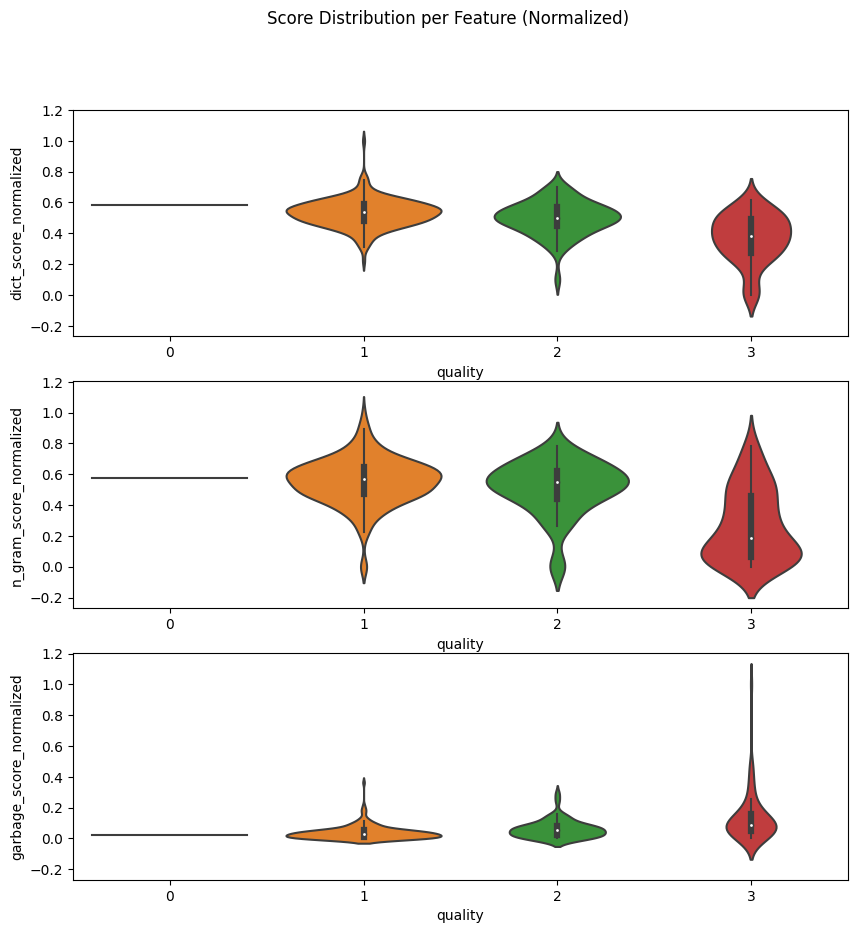

In [303]:
fig, axs = plt.subplots(
    nrows=len(x_fields_normalized), figsize=(10, 10), sharex=False, sharey=True
)

fig.suptitle("Score Distribution per Feature (Normalized)")

for field, ax in zip(x_fields_normalized, axs):
    # ax.set_title(field)
    ax.set_ylabel(field)
    ax.set_xlabel(y_field)

    sns.violinplot(x=filtered[y_field], y=filtered[field], ax=ax)



In [231]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(filtered, test_size=0.2, random_state=0)
train, test


(     Pagina Beoordeling  Opmerkingen Kay  Ranking Kay Oordeel Maartje  \
 1         2        Goed              NaN            1            goed   
 426     427        Goed              NaN            1            goed   
 9        10        Goed              NaN            1            goed   
 324     325      Slecht  Regioherkenning            3          slecht   
 151     152        goed              NaN            1            goed   
 ..      ...         ...              ...          ...             ...   
 488     489        Goed              NaN            1            goed   
 294     295      Medium       Marginalia            2          medium   
 176     177      Slecht              NaN            3          slecht   
 72       73      Slecht           Layout            3          slecht   
 262     263      Slecht              NaN            3          slecht   
 
       Opmerkingen Maartje  Ranking Maartje  Som                    Filename  \
 1                     NaN    

In [232]:
X = train[x_fields_normalized]
y = train[y_field]

X_test = test[x_fields_normalized]


### KNN

In [233]:
from sklearn.neighbors import KNeighborsClassifier


n = 5

knn_classifier = KNeighborsClassifier(n_neighbors=n)
knn_classifier.fit(X, y)


KNeighborsClassifier()

In [305]:
column = "prediction_knn"

test[column] = knn_classifier.predict(X_test)

correct = len(test.loc[test[y_field] == test[column]])

total = len(test)

print(f"Correctly Classified:\t{correct}")
print(f"Total Test Samples:\t{total}")
print(f"Accuracy:\t{correct/total}")


Correctly Classified:	47
Total Test Samples:	66
Accuracy:	0.7121212121212122


### Nearest Centroid

In [236]:
from sklearn.neighbors import NearestCentroid

shrinkage=None

nc = NearestCentroid(shrink_threshold=shrinkage)
nc.fit(X, y)


NearestCentroid()

In [306]:
column = "prediction_nc"

test[column] = knn_classifier.predict(X_test)

correct = len(test.loc[test[y_field] == test[column]])

total = len(test)

print(f"Correctly Classified:\t{correct}")
print(f"Total Test Samples:\t{total}")
print(f"Accuracy:\t{correct/total}")


Correctly Classified:	47
Total Test Samples:	66
Accuracy:	0.7121212121212122


### Decision Tree

In [241]:
from sklearn import tree

max_depth = 3

decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
decision_tree.fit(X, y)


DecisionTreeClassifier(max_depth=3)

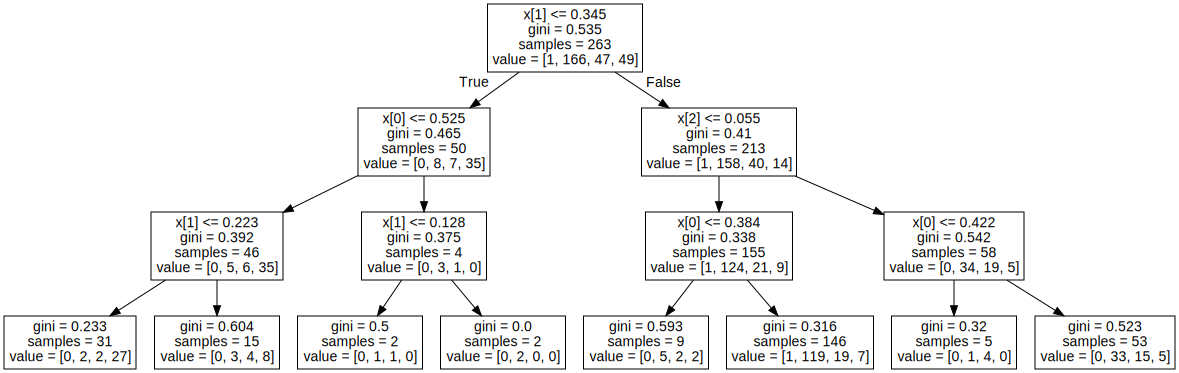

In [243]:
import graphviz

dot_data = tree.export_graphviz(decision_tree, out_file=None)
graph = graphviz.Source(dot_data)
graph


In [307]:
column = "prediction_decision_tree"

test[column] = knn_classifier.predict(X_test)

correct = len(test.loc[test[y_field] == test[column]])

total = len(test)

print(f"Correctly Classified:\t{correct}")
print(f"Total Test Samples:\t{total}")
print(f"Accuracy:\t{correct/total}")


Correctly Classified:	47
Total Test Samples:	66
Accuracy:	0.7121212121212122


### Random Forest

In [246]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(max_depth=max_depth)
random_forest.fit(X, y)


RandomForestClassifier(max_depth=3)

In [247]:
column = "prediction_random_forest"

test[column] = random_forest.predict(X_test)

correct = len(test.loc[test[y_field] == test[column]])

total = len(test)

print(f"Correctly Classified:\t{correct}")
print(f"Total Test Samples:\t{total}")
print(f"Accuracy:\t{correct/total}")


Correctly Classified:	49
Total Test Samples:	66
Accuracy:	0.7424242424242424


### SVM

In [248]:
from sklearn import svm

svm_classifier = svm.SVC()
svm_classifier.fit(X, y)

SVC()

In [249]:
column = "prediction_svm"

test[column] = random_forest.predict(X_test)

correct = len(test.loc[test[y_field] == test[column]])

total = len(test)

print(f"Correctly Classified:\t{correct}")
print(f"Total Test Samples:\t{total}")
print(f"Accuracy:\t{correct/total}")


Correctly Classified:	49
Total Test Samples:	66
Accuracy:	0.7424242424242424


### Multi-layer Perceptron

In [250]:
from sklearn import neural_network

nn = neural_network.MLPClassifier()
nn.fit(X, y)


/Users/carstenschnober/opt/anaconda3/envs/lahter/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [251]:
column = "prediction_nn"

test[column] = random_forest.predict(X_test)

correct = len(test.loc[test[y_field] == test[column]])

total = len(test)

print(f"Correctly Classified:\t{correct}")
print(f"Total Test Samples:\t{total}")
print(f"Accuracy:\t{correct/total}")


Correctly Classified:	49
Total Test Samples:	66
Accuracy:	0.7424242424242424


In [252]:
test.filter(like="prediction")


,prediction_knn,prediction_nc,prediction_decision_tree,prediction_random_forest,prediction_svm,prediction_nn
183,1,0,1,1,1,1
104,1,3,3,3,3,3
220,1,2,1,1,1,1
367,1,0,1,1,1,1
225,1,0,1,1,1,1
...,...,...,...,...,...,...
352,1,0,1,1,1,1
115,1,2,1,1,1,1
79,1,0,1,1,1,1
353,1,2,1,1,1,1
